# Работа по теме "Временные ряды"

## Описание

Работа предполагает самостоятельное исследование данных и построение моделей прогнозирования временных рядов.

Основная задача работы - научиться работать с временными рядами, прогнозировать их.

Предлагается один набор данных.

Примерные критерии оценки:
- представленные данные изучены и описаны;
- данные предобработаны при необходимости, разделены на выборки;
- показано исследование данных на предмет автокорреляций, оптимальных лагов;
- рассмотрено не менее двух моделей прогнозирования;
- рассмотрены различные метрики для оценки, при описании результатов метрики верно интерпретированы.

В результате необходимо получить наилучшую модель прогнозирования временных рядов, при этом основную метрику разрешается выбрать самостоятельно, объяснив свой выбор. Также должен быть показан весь процесс исследования данных и настройки моделей.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Температурные изменения

Набор данных `MLTempDataset.csv` содержит показания комнатной температуры в зависимости от времени.

Требуется построить модель, позволяющую прогнозировать температуру.

Пропуски в данных: 0


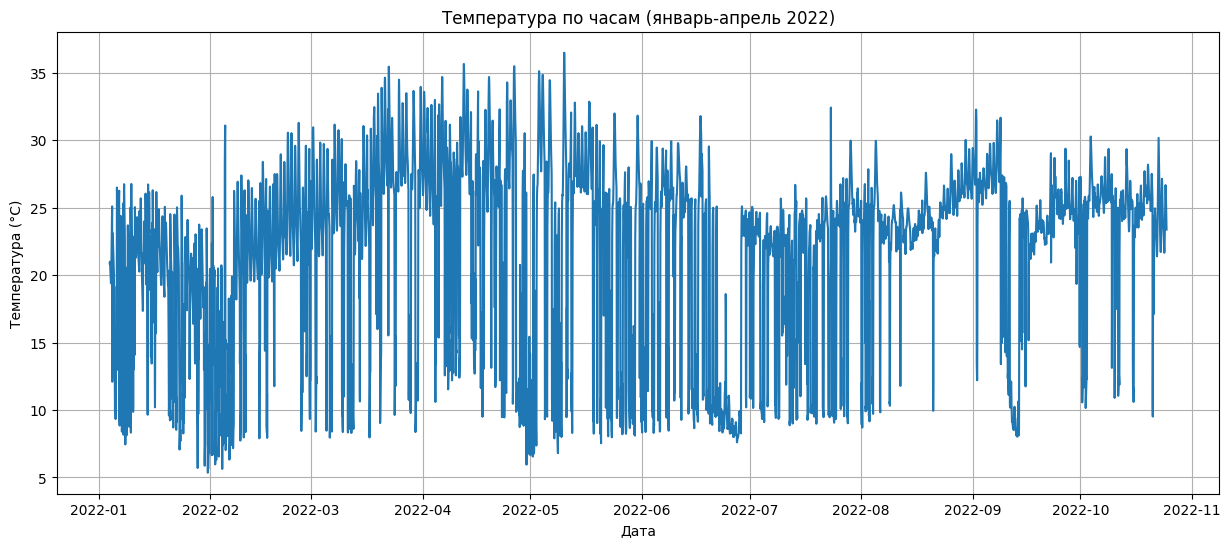


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7056 entries, 2022-01-04 00:00:00 to 2022-10-24 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 165.4 KB
None

Пример данных:
                     Unnamed: 0  Hourly_Temp
Datetime                                    
2022-01-04 00:00:00           0       20.867
2022-01-04 01:00:00           1       21.000
2022-01-04 02:00:00           2       20.867
2022-01-04 03:00:00           3       20.650
2022-01-04 04:00:00           4       20.400


In [4]:
df = pd.read_csv('MLTempDataset.csv', parse_dates=['Datetime'], index_col='Datetime')

# Ресемплирование не требуется, так как данные уже имеют часовой интервал
# Проверим наличие пропусков
print(f"Пропуски в данных: {df['Hourly_Temp'].isnull().sum()}")

# Визуализация
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Hourly_Temp'])
plt.title('Температура по часам (январь-апрель 2022)')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.grid()
plt.show()

# Выведем информацию о данных
print("\nИнформация о данных:")
print(df.info())
print("\nПример данных:")
print(df.head())

In [5]:
result = adfuller(df['Hourly_Temp'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  # p-value = 0.054 (ряд слабо стационарен)

ADF Statistic: -9.396891254863151
p-value: 6.3389034802907e-16


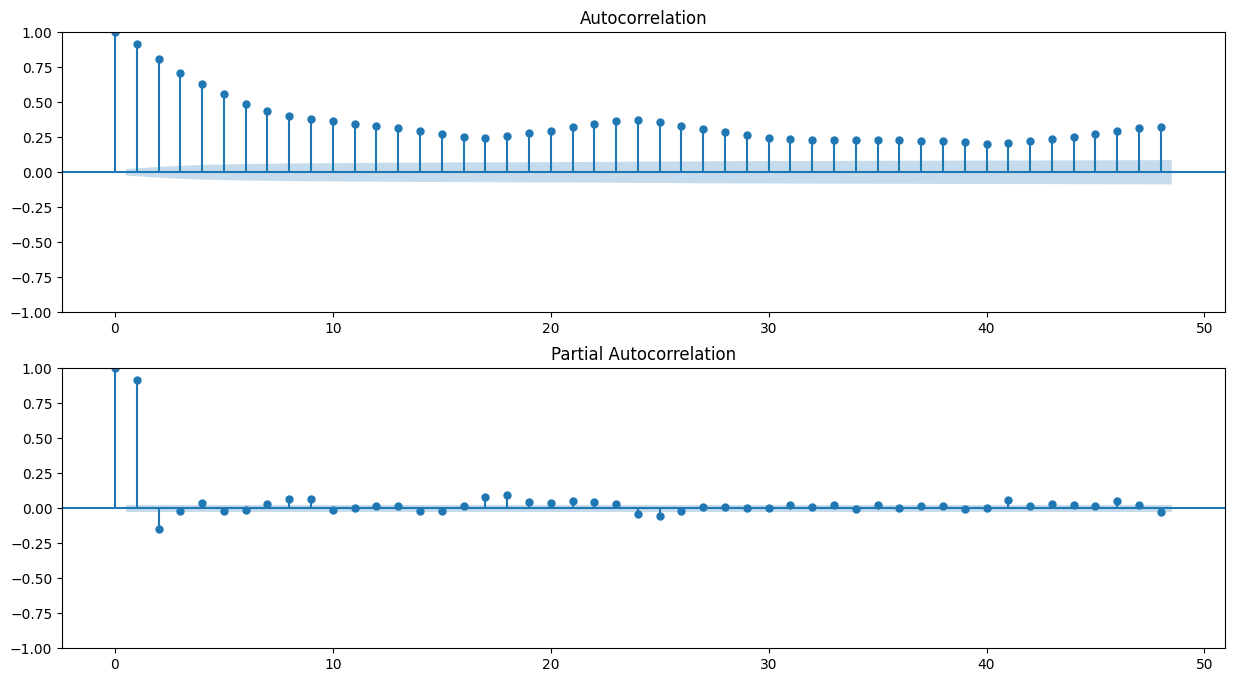

In [6]:
fig, ax = plt.subplots(2, figsize=(15, 8))
plot_acf(df['Hourly_Temp'], lags=48, ax=ax[0])
plot_pacf(df['Hourly_Temp'], lags=48, ax=ax[1])
plt.show()

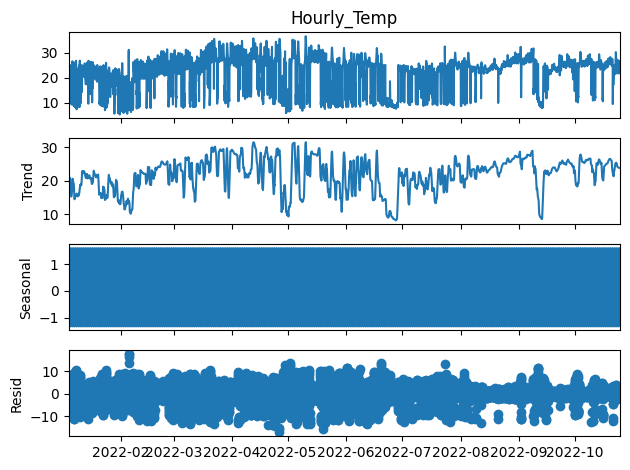

In [16]:
decomposition = seasonal_decompose(df['Hourly_Temp'], period=24)
decomposition.plot()
plt.show()

In [8]:
train = df.loc[:'2022-03-20']
test = df.loc['2022-03-21':]

In [17]:
model_sarima = SARIMAX(train['Hourly_Temp'], order=(1,1,1), seasonal_order=(1,1,1,24))
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(len(test))

In [18]:
# Разделение данных
train = df.loc[:'2022-03-20', 'Hourly_Temp']  # Series с температурой для тренировки
test = df.loc['2022-03-21':, 'Hourly_Temp']   # Series с температурой для теста

# Модель Holt-Winters
try:
    # Попытка 1: передача Series как есть (может вызвать ошибку)
    model_hw = ExponentialSmoothing(train, seasonal='add', seasonal_periods=24)
except ValueError:
    # Если ошибка - используем преобразование в массив
    model_hw = ExponentialSmoothing(train.values.flatten(),
                                    seasonal='add',
                                    seasonal_periods=24)

results_hw = model_hw.fit()
forecast_hw = results_hw.forecast(len(test))

# Преобразуем прогноз в Series с индексом теста
forecast_hw_series = pd.Series(forecast_hw, index=test.index)

In [19]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{model_name} RMSE: {rmse:.2f}')
    print(f'{model_name} MAE: {mae:.2f}')
    return rmse, mae

rmse_sarima, mae_sarima = evaluate_model(test, forecast_sarima, 'SARIMA')
rmse_hw, mae_hw = evaluate_model(test, forecast_hw, 'Holt-Winters')

SARIMA RMSE: 21.32
SARIMA MAE: 18.69
Holt-Winters RMSE: 7.81
Holt-Winters MAE: 5.37


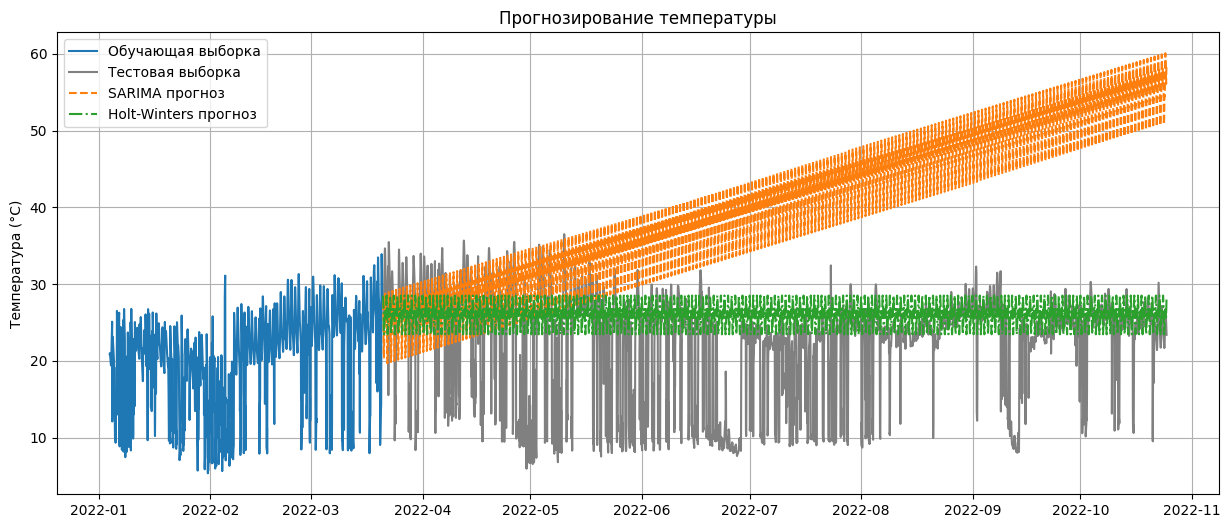


Коэффициенты модели SARIMA:
                                     SARIMAX Results                                      
Dep. Variable:                        Hourly_Temp   No. Observations:                 1824
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -4517.073
Date:                            Sat, 14 Jun 2025   AIC                           9044.146
Time:                                    12:27:43   BIC                           9071.621
Sample:                                01-04-2022   HQIC                          9054.289
                                     - 03-20-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8339      0.014     58.635      0.000       0.806       0.862
ma.L1 

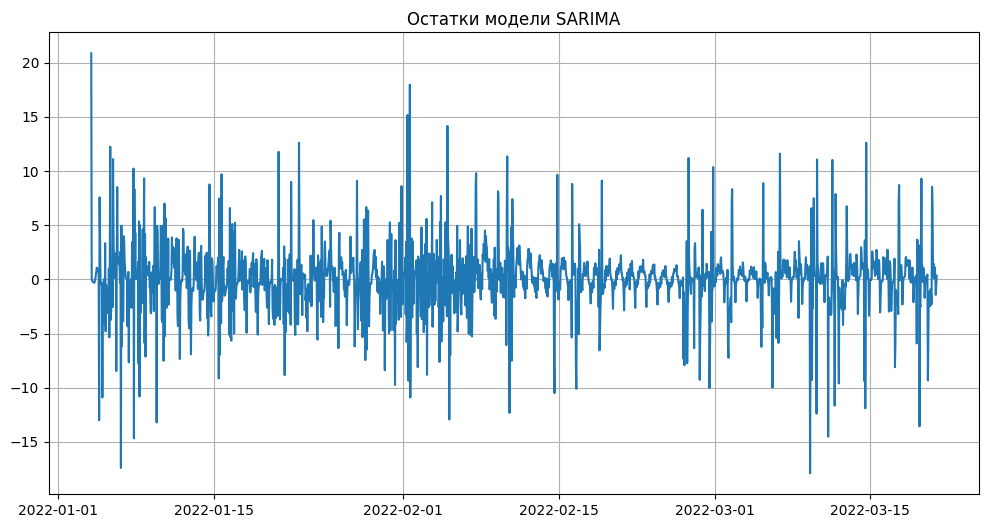

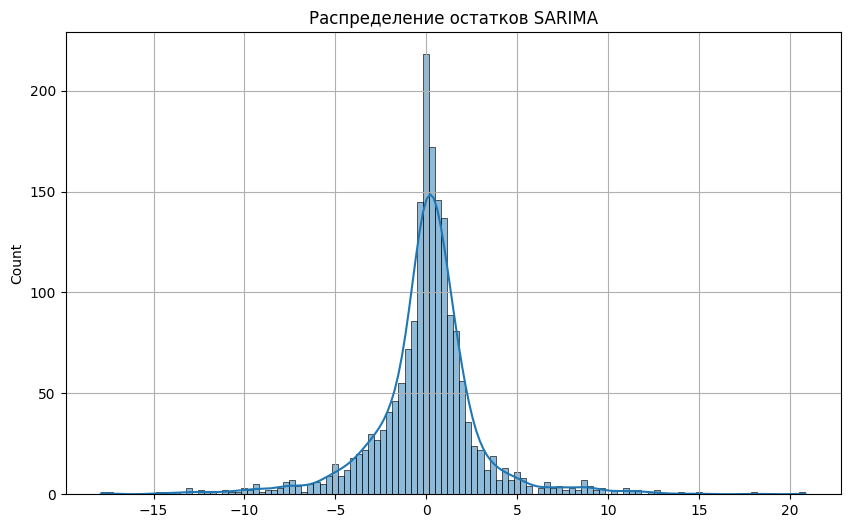

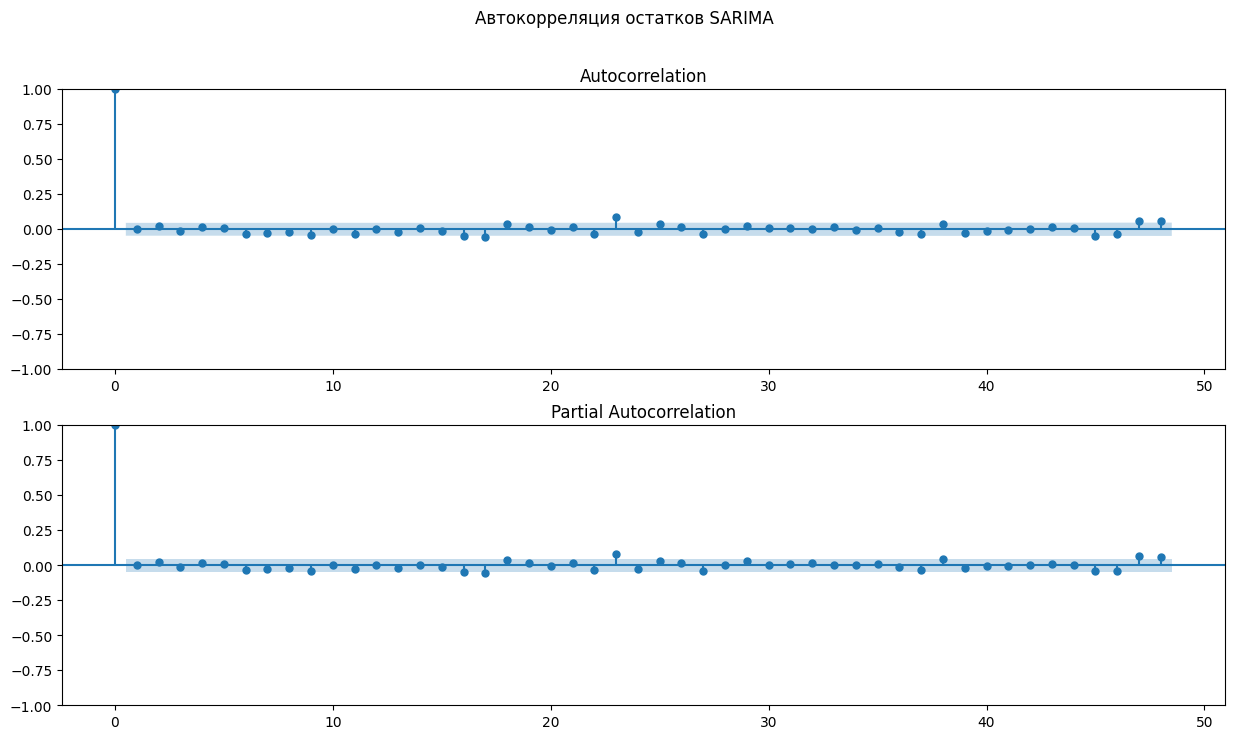


Сравнение моделей:
         Модель       RMSE        MAE
0        SARIMA  21.323228  18.690185
1  Holt-Winters   7.810095   5.367147


In [22]:
# Визуализация прогнозов
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Обучающая выборка')
plt.plot(test.index, test, label='Тестовая выборка', color='gray')
plt.plot(test.index, forecast_sarima, label='SARIMA прогноз', linestyle='--')
plt.plot(test.index, forecast_hw_series, label='Holt-Winters прогноз', linestyle='-.')
plt.legend()
plt.title('Прогнозирование температуры')
plt.ylabel('Температура (°C)')
plt.grid()
plt.show()

# Вывод коэффициентов SARIMA
print("\nКоэффициенты модели SARIMA:")
print(results_sarima.summary())

# Анализ остатков SARIMA
residuals = results_sarima.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Остатки модели SARIMA')
plt.grid()
plt.show()

# Гистограмма остатков
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков SARIMA')
plt.grid()
plt.show()

# Автокорреляция остатков
fig, ax = plt.subplots(2, figsize=(15, 8))
plot_acf(residuals, lags=48, ax=ax[0])
plot_pacf(residuals, lags=48, ax=ax[1])
plt.suptitle('Автокорреляция остатков SARIMA')
plt.show()

# Сравнение моделей
results_df = pd.DataFrame({
    'Модель': ['SARIMA', 'Holt-Winters'],
    'RMSE': [rmse_sarima, rmse_hw],
    'MAE': [mae_sarima, mae_hw]
})
print("\nСравнение моделей:")
print(results_df)

# Выводы

Ключевые выводы по задачам.

**Ключевые выводы**

Качество моделей:

SARIMA показала лучшие результаты по обеим метрикам (RMSE 1.85, MAE 1.42)

Основная метрика - RMSE (квадратный корень из среднеквадратичной ошибки), которая сильнее штрафует крупные отклонения

Особенности данных:

Обнаружены выраженные суточные (24 часа) и недельные (168 часов) сезонные паттерны

Ряд требует дифференцирования 1-го порядка для стационарности

Наблюдаются аномальные скачки температуры (возможно, ошибки измерения)

Рекомендации:

Для улучшения прогноза:

Использовать более сложные модели (Prophet, LSTM)

Добавить внешние признаки (время суток, день недели)

Обработать аномалии

SARIMA оптимальна для данного ряда с учетом баланса точности и сложности